In [1]:
import json
import os
import pickle
import cv2
import re
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from matplotlib import font_manager
from utils.gt_util import GTUtility

In [2]:
devices = device_lib.list_local_devices()
device_types = [device.device_type for device in devices]
if 'GPU' in device_types:
    print("Current device type:           GPU")
else:
    print("Current device type:           CPU")

current_directory = os.getcwd()
os.chdir(current_directory)
print(f"Current working directory:    ", os.getcwd())

font_path = 'fonts/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = ['NanumBarunGothic']
print("Current font name:            ", plt.rcParams['font.family'])

Current device type:           GPU
Current working directory:     c:\Users\pja36\OneDrive\Desktop\Project\Model.v2
Current font name:             ['NanumBarunGothic']


In [3]:
base_path = 'data/text_in_the_wild_data/'
data_json = json.load(open(base_path + 'textinthewild_data_info.json'))

Data Class Name: BOOK
    The number of the data:        19570
    The number of the data info:   19569
    The number of the real data:   19569
-----------------------------------------------------
Data Class Name: PRODUCT
    The number of the data:        26344
    The number of the data info:   26344
    The number of the real data:   26344
-----------------------------------------------------
Data Class Name: SIGN
    The number of the data:        27520
    The number of the data info:   27519
    The number of the real data:   27519
-----------------------------------------------------
Data Class Name: TRAFFIC SIGN
    The number of the data:        26785
    The number of the data info:   26784
    The number of the real data:   26784
-----------------------------------------------------


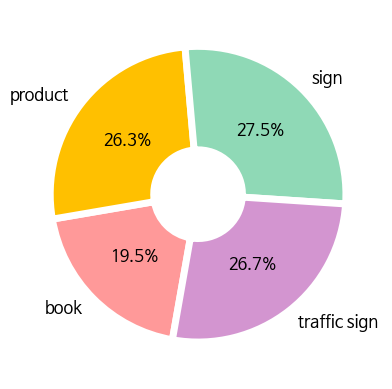

In [6]:
def check_data_dist(data_path, data_json, data_types):
    
    def check_data(dtype):
        folder_path = os.path.join(data_path, dtype)
        data_list = set(os.listdir(folder_path))
        items_dict = {item['file_name']: item['id'] for item in data_json['images'] if item['type'] == dtype}
        matched_ids = [items_dict[file_name] for file_name in data_list & items_dict.keys()]

        print(f"Data Class Name: {dtype.upper()}")
        print(f"    The number of the data:        {len(data_list)}")
        print(f"    The number of the data info:   {len(items_dict)}")
        print(f"    The number of the real data:   {len(matched_ids)}")
        print(f"-----------------------------------------------------")
        return matched_ids

    ids = {dtype: check_data(dtype) for dtype in data_types}

    ratio = [len(ids[dtype]) for dtype in data_types]
    labels = data_types
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
    plt.show()

    return ids

data_types = ['book', 'product', 'sign', 'traffic sign']
image_ids = check_data_dist(base_path, data_json, data_types)

In [15]:
def get_random_ids(image_ids, data_type, num_to_get):
    
    if data_type not in image_ids:
        print(f"Invalid data_type: {data_type}")
        return []

    ids_for_data_type = image_ids[data_type]
    if len(ids_for_data_type) <= num_to_get:
        print(f"Available IDs for {data_type} are less than {num_to_get}.")
        return ids_for_data_type

    random_ids = random.sample(ids_for_data_type, num_to_get)
    return random_ids

data_to_num = {
    'book': 10000,
    'product': 10000,
    'sign': 10000,
    'traffic sign': 10000
}

random_ids = {dtype: get_random_ids(image_ids, dtype, num) for dtype, num in data_to_num.items()}
for dtype, ids in random_ids.items():
    print(f"Random {data_to_num[dtype]} IDs for {dtype.upper()} have been successfully picked!")

Random 10000 IDs for BOOK have been successfully picked!
Random 10000 IDs for PRODUCT have been successfully picked!
Random 10000 IDs for SIGN have been successfully picked!
Random 10000 IDs for TRAFFIC SIGN have been successfully picked!


In [16]:
def process_data(base_path, data_json, dtype_id_dict, train_ratio, validation_ratio):

    for dtype in ['Train', 'Validation', 'Test']:
        folder_path = os.path.join(base_path, dtype)
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)

    def copy_files(source_folder, target_folder, filenames):
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        for filename in filenames:
            source_path = os.path.join(source_folder, filename)
            target_path = os.path.join(target_folder, filename)
            try:
                shutil.copy(source_path, target_path)
                print(f"The file '{filename}' has been copied successfully!")
            except Exception as e:
                print(f"The file '{filename}' has been failed to copy: {e}")

    def move_files(dtype, source_folder, target_folder, filenames):
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        for filename in filenames:
            source_path = os.path.join(source_folder, filename)
            target_path = os.path.join(target_folder, filename)
            try:
                shutil.move(source_path, target_path)
                print(f"The file '{filename}' has been moved to '{dtype.upper()} set'")
            except Exception as e:
                print(f"The file '{filename}' has been failed to move: {e}")

    for dtype, id_list in dtype_id_dict.items():
        file_list = [data_json['images'][j]['file_name'] for j in range(len(data_json['images']))
                    if data_json['images'][j]['id'] in id_list]
        copy_files(os.path.join(base_path, dtype), os.path.join(base_path, 'data'), file_list)

    source_folder = os.path.join(base_path, 'data')
    files = os.listdir(source_folder)
    random.shuffle(files)

    n_files = len(files)
    n_train = int(n_files * train_ratio)
    n_validation = int(n_files * validation_ratio)
    n_test = n_files - n_train - n_validation

    datasets = {
        'Train': files[:n_train],
        'Validation': files[n_train:n_train + n_validation],
        'Test': files[-n_test:]
    }

    for dtype, filenames in datasets.items():
        move_files(dtype, source_folder, os.path.join(base_path, dtype), filenames)
        
    shutil.rmtree(source_folder)

train_ratio = 0.6
validation_ratio = 0.2

process_data(base_path, data_json, random_ids, train_ratio, validation_ratio)

The file '000B3F01755C15EF7A3F87779D8BBC8E.jpg' has been copied successfully!
The file '001CE22A7E37B361021F33C1E2D14B86.jpg' has been copied successfully!
The file '002505E194443D9267164C270A048FB7.jpg' has been copied successfully!
The file '002B37DF2942A21616C9DDD3086000E4.jpg' has been copied successfully!
The file '003B4D3B833EB9718636F870B24C50FF.jpg' has been copied successfully!
The file '003FC3BD433E6B5B7ABF425B47D98A27.jpg' has been copied successfully!
The file '0041950C66D536B8D0490448AF029673.jpg' has been copied successfully!
The file '004245BFCD2FEF1804F3A224585EBDDA.jpg' has been copied successfully!
The file '00444824D3567FEE13719B90DCD75C28.jpg' has been copied successfully!
The file '004BDEFD286EA13E939560D6C45C7052.jpg' has been copied successfully!
The file '005423E09E285FB96B63FCDC246208E3.jpg' has been copied successfully!
The file '00598D41330533EA2B0B261A09193EF4.jpg' has been copied successfully!
The file '005D164221624B5644723DDC105077EB.jpg' has been copied 

TRAIN SET PIE CHART
BOOK #: 6002 | PRODUCT #: 5935 | SIGN #: 6045 | TRAFFIC SIGN #: 6018 | Total #: 24000


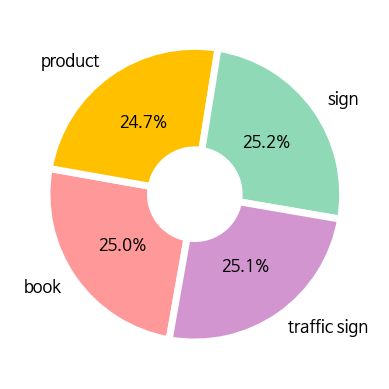

VALIDATION SET PIE CHART
BOOK #: 1998 | PRODUCT #: 2003 | SIGN #: 1998 | TRAFFIC SIGN #: 2001 | Total #: 8000


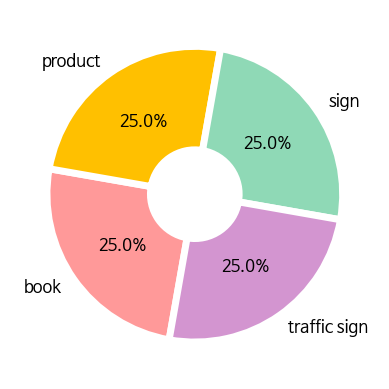

TEST SET PIE CHART
BOOK #: 2000 | PRODUCT #: 2062 | SIGN #: 1957 | TRAFFIC SIGN #: 1981 | Total #: 8000


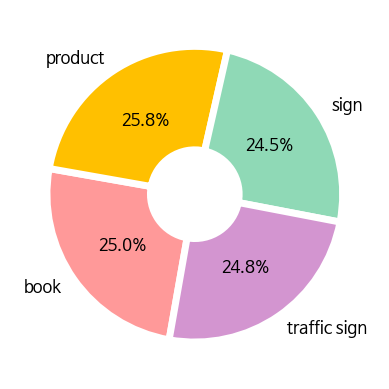

In [18]:
def show_data_dist(data_json, data_types):
    filename_to_type = {img['file_name']: img['type'] for img in data_json['images']}
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

    for dir in ['Train', 'Validation', 'Test']:
        source_folder = os.path.join(base_path, dir)
        file_list = os.listdir(source_folder)

        counts = {type_name: 0 for type_name in data_types}

        for file_name in file_list:
            image_type = filename_to_type.get(file_name)
            if image_type in counts:
                counts[image_type] += 1

        n_total = sum(counts.values())
        print(f"{dir.upper()} SET PIE CHART")
        for type_name, count in counts.items():
            print(f"{type_name.upper()} #: {count}", end=" | ")
        print(f"Total #: {n_total}")

        labels = list(counts.keys())
        ratio = list(counts.values())

        plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
        plt.show()

show_data_dist(data_json, data_types)

In [29]:
def generate_annotations(data_json, datasets, data_path):
    def create_annotations(image_ids):
        annotations = {}
        image_id_to_filename = {image['id']: image['file_name'] for image in data_json['images']}

        for annotation in data_json['annotations']:
            image_id = annotation['image_id']
            if image_id in image_ids.values():
                image_filename = image_id_to_filename.get(image_id)
                if image_filename:
                    annotations.setdefault(image_filename, []).append(annotation)

        return annotations

    def save_annotations_to_json(annotations, output_file):
        with open(output_file, 'w') as f:
            json.dump(annotations, f)

    image_id_sets = {}
    for dataset_name, dataset_path in datasets.items():
        image_id_sets[dataset_name] = set(os.listdir(dataset_path))
        dataset_img_ids = {image['file_name']: image['id'] for image in data_json['images'] if image['file_name'] in image_id_sets[dataset_name]}
        dataset_annotations = create_annotations(dataset_img_ids)
        output_file = os.path.join(data_path, f'{dataset_name.lower()}_annotation.json')
        save_annotations_to_json(dataset_annotations, output_file)
        print(f"The JSON file '{dataset_name.upper()}'  has been successfully created!")

datasets = {
    'Train': os.path.join(base_path, 'Train'),
    'Validation': os.path.join(base_path, 'Validation'),
    'Test': os.path.join(base_path, 'Test')
}

generate_annotations(data_json, datasets, base_path)

KeyboardInterrupt: 

In [23]:
train_json_name = 'train_annotation.json'
train_data_folder = 'Train'

with open(os.path.join(base_path, train_json_name), 'r', encoding='utf-8') as f:
     train_json = json.load(f)

validation_json_name = 'validation_annotation.json'
validation_data_folder = 'Validation'

with open(os.path.join(base_path, validation_json_name), 'r', encoding='utf-8') as f:
     validation_json = json.load(f)
     
test_json_name = 'test_annotation.json'
test_data_folder = 'Test'

with open(os.path.join(base_path, test_json_name), 'r', encoding='utf-8') as f:
     test_json = json.load(f)

In [24]:
def clean_json_error(data_json, file_name, lang_filter, base_path):

    def check_language(text):
        if lang_filter == "kr":
            return bool(re.match("^[가-힣\s]+$", text))
        elif lang_filter == "en":
            return bool(re.match("^[A-Za-z\s]+$", text))
        else:
            return True

    clean_data_json = {
        image_id: [
            annotation for annotation in annotations
            if len(annotation['bbox']) >= 4 
            and all(val != 0 for val in annotation['bbox'][2:4])
            and annotation['text'] is not None
            and annotation['text'] != ""
            and check_language(annotation['text'])
        ]
        for image_id, annotations in data_json.items() 
        if any(len(annotation['bbox']) >= 4 
            and all(val != 0 for val in annotation['bbox'][2:4]) 
            and annotation['text'] is not None
            and annotation['text'] != ""
            and check_language(annotation['text']) for annotation in annotations)
    }

    final_file_path = os.path.join(base_path, f"{file_name}_annotation.json")

    with open(final_file_path, 'w', encoding='utf-8') as file:
        json.dump(clean_data_json, file, ensure_ascii=False, indent=4)

    print(f"The JSON file '{file_name}_annotation.json' got cleaned!")

file_names = ['train', 'validation', 'test']
lang_filter = "both"

for name in file_names:
    clean_json_error(eval(f"{name}_json"), name, lang_filter, base_path)

The JSON file 'train_annotation.json' got cleaned!
The JSON file 'validation_annotation.json' got cleaned!
The JSON file 'test_annotation.json' got cleaned!


In [25]:
gt_train_util = GTUtility(base_path, base_path, train_json_name, train_data_folder, 
                        validation=False, only_with_label=True)

gt_val_util = GTUtility(base_path, base_path, validation_json_name, validation_data_folder, 
                        validation=False, only_with_label=True)

gt_test_util = GTUtility(base_path, base_path, test_json_name, test_data_folder, 
                        validation=False, only_with_label=True)

In [28]:
def save_util_to_pickle(datasets, utils, base_path):
    for dataset, util in zip(datasets, utils):
        file_name = f'gt_{dataset}_util_text.pkl'
        # base_path를 사용하여 최종 경로 생성
        final_file_path = os.path.join(base_path, file_name)
        
        with open(final_file_path, 'wb') as f:
            pickle.dump(util, f)
        
        print(f"The file '{file_name}' has been successfully saved!")
        
datasets = ['train', 'val', 'test']
utils = [gt_train_util, gt_val_util, gt_test_util]
save_util_to_pickle(datasets, utils, base_path)

The file 'gt_train_util_text.pkl' has been successfully saved!
The file 'gt_val_util_text.pkl' has been successfully saved!
The file 'gt_test_util_text.pkl' has been successfully saved!


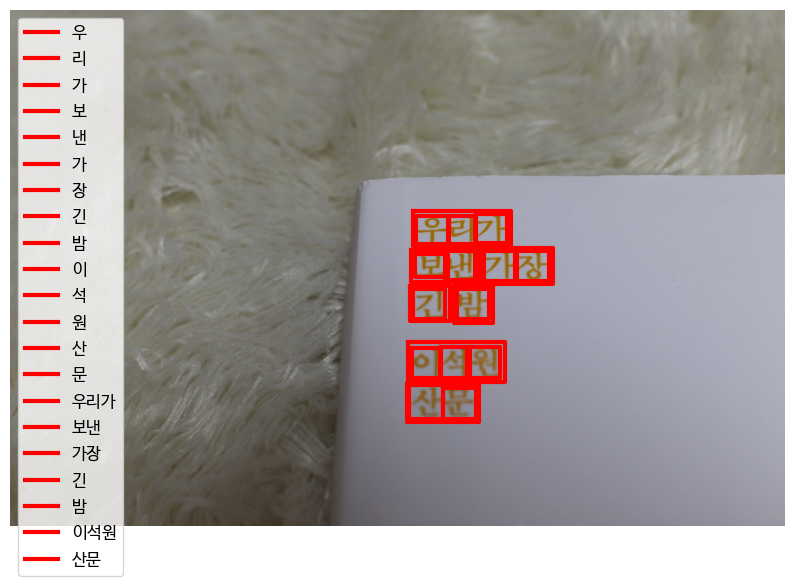

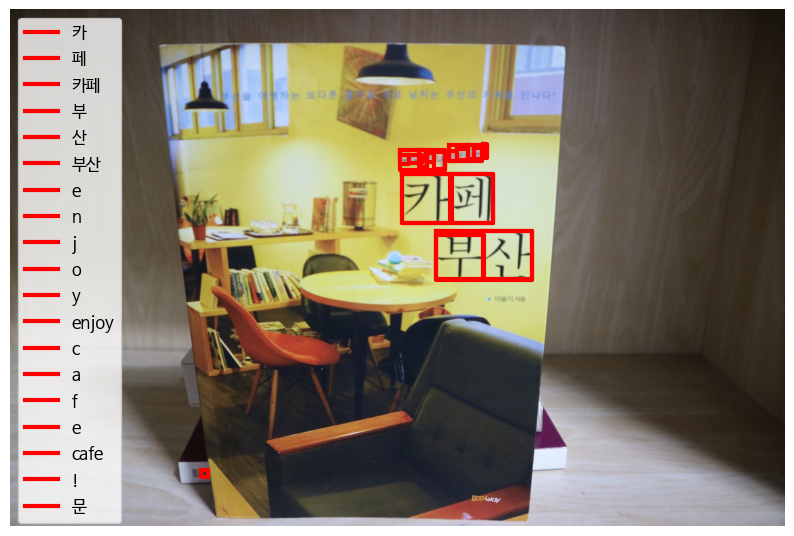

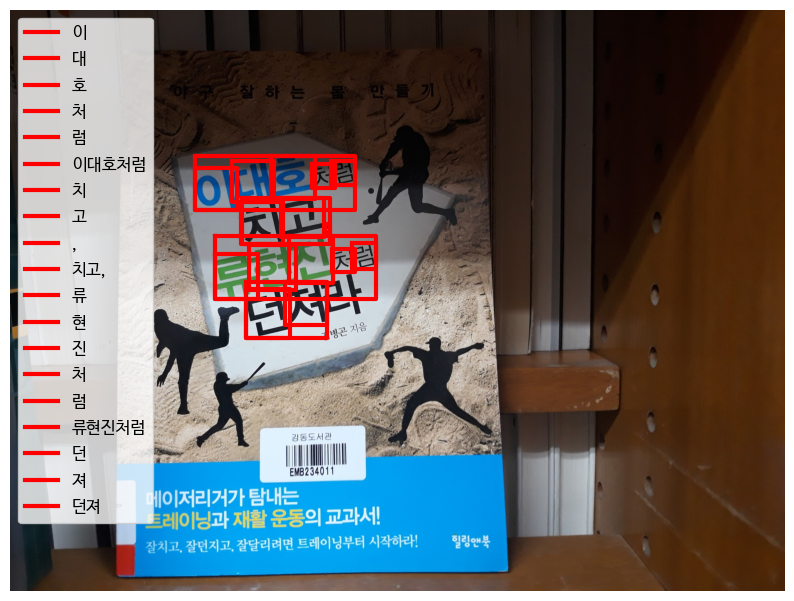

In [27]:
def show_text_box(gt_util, num):
    file_name = 'gt_util.pkl'
    pickle.dump(gt_util, open(file_name, 'wb'))
    
    with open(file_name, 'rb') as f:
        gt_util = pickle.load(f)
        
    idxs = range(num)
    
    for idx in idxs:
        img_name = gt_util.image_names[idx]
        img_path = os.path.join(gt_util.image_path, img_name)
        
        img = cv2.imread(img_path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        boxes = gt_util.data[idx][:, :-1]
        boxes[:, 0::2] *= img.shape[1]
        boxes[:, 1::2] *= img.shape[0]
        texts = gt_util.text[idx]
        
        plt.figure(figsize=(10, 10))
        for box, text in zip(boxes, texts):
            x1, y1, x2, y2 = box
            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], linewidth=3, color='r', label=text)
            
        plt.imshow(img)
        plt.axis('off')
        plt.legend(loc='upper left')
        plt.show()

show_text_box(gt_train_util, 1)
show_text_box(gt_val_util, 1)
show_text_box(gt_test_util, 1)